In [ ]:
import pandas as pd
import json
import  nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data Preprocessing


In [ ]:
# Path ke folder yang berisi file JSON
folder_path = '/content/drive/MyDrive/YELP DATASET/'
file_path = folder_path + 'yelp_academic_dataset_review.json'

# Memuat data JSON
data_list = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        data_list.append(json.loads(line))

In [ ]:
# Mengubah data JSON menjadi DataFrame
df = pd.json_normalize(data_list)
print(df.head())
print()
print(df.info())

                  user_id               review_id  stars        date  \
0  Xqd0DzHaiyRqVH3WRG7hzg  15SdjuK7DmYqUAj6rjGowg      5  2007-05-17   
1  H1kH6QZV7Le4zqTRNxoZow  RF6UnRTtG7tWMcrO2GEoAg      2  2010-03-22   
2  zvJCcrpm2yOZrxKffwGQLA  -TsVN230RCkLYKBeLsuz7A      4  2012-02-14   
3  KBLW4wJA_fwoWmMhiHRVOA  dNocEAyUucjT371NNND41Q      4  2012-03-02   
4  zvJCcrpm2yOZrxKffwGQLA  ebcN2aqmNUuYNoyvQErgnA      4  2012-05-15   

                                                text    type  \
0  dr. goldberg offers everything i look for in a...  review   
1  Unfortunately, the frustration of being Dr. Go...  review   
2  Dr. Goldberg has been my doctor for years and ...  review   
3  Been going to Dr. Goldberg for over 10 years. ...  review   
4  Got a letter in the mail last week that said D...  review   

              business_id  votes.funny  votes.useful  votes.cool  
0  vcNAWiLM4dR7D2nwwJ7nCA            0             2           1  
1  vcNAWiLM4dR7D2nwwJ7nCA            0          

In [ ]:
df.isnull().sum()

user_id         0
review_id       0
stars           0
date            0
text            0
type            0
business_id     0
votes.funny     0
votes.useful    0
votes.cool      0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
dat = df[['text','business_id']]
dat.head()

,text,business_id
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA


In [ ]:
# cutting df
data = dat.loc[0:499]
data

,text,business_id
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA
...,...,...
495,You're getting an extra star for two solid rea...,eT5Ck7Gg1dBJobca9VFovw
496,This is easily one of the best Giant Eagles I'...,eT5Ck7Gg1dBJobca9VFovw
497,This place has amazing selection when it comes...,eT5Ck7Gg1dBJobca9VFovw
498,"oddly enough, of all the giant eagles i have v...",eT5Ck7Gg1dBJobca9VFovw


In [ ]:
text = ' '.join(data['text'])

print(text)

dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank. Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with

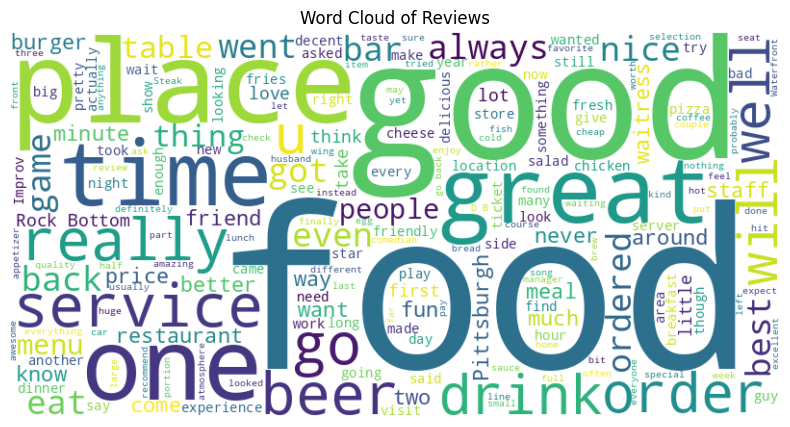

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

## Data Cleaning (regex&lowercase)

In [ ]:
import re

def remove_punctuation(text):
    # Define a regex pattern that matches all common punctuation marks
    pattern = r'[.,"\'?!:;()\[\]{}—\-…/\\|@#\$%^&*_=+~`<>]'
    return re.sub(pattern, '', text)

# Apply the function to the 'text' column of the DataFrame and lower the case
data['clear_text'] = data['text'].apply(lambda x: remove_punctuation(x).lower())


<ipython-input-48-836246523159>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clear_text'] = data['text'].apply(lambda x: remove_punctuation(x).lower())


In [ ]:
data.head()

,text,business_id,clear_text
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg offers everything i look for in a ...
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA,unfortunately the frustration of being dr gold...
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg has been my doctor for years and i...
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA,been going to dr goldberg for over 10 years i ...
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA,got a letter in the mail last week that said d...


## Tokenisasi

In [ ]:
import spacy

data['tokens'] = data['clear_text'].apply(lambda x: x.split())

<ipython-input-50-730903b49f78>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokens'] = data['clear_text'].apply(lambda x: x.split())


##Stopwords

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  token = word_tokenize(text)

  stopwords_deleted = [word for word in token if word.lower() not in stop_words]

  return stopwords_deleted

data['non_stopwords'] = data['clear_text'].apply(remove_stopwords)

<ipython-input-51-5dc68a27e097>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['non_stopwords'] = data['clear_text'].apply(remove_stopwords)


In [ ]:
data.head()

,text,business_id,clear_text,tokens,non_stopwords
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg offers everything i look for in a ...,"[dr, goldberg, offers, everything, i, look, fo...","[dr, goldberg, offers, everything, look, gener..."
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA,unfortunately the frustration of being dr gold...,"[unfortunately, the, frustration, of, being, d...","[unfortunately, frustration, dr, goldbergs, pa..."
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg has been my doctor for years and i...,"[dr, goldberg, has, been, my, doctor, for, yea...","[dr, goldberg, doctor, years, like, ive, found..."
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA,been going to dr goldberg for over 10 years i ...,"[been, going, to, dr, goldberg, for, over, 10,...","[going, dr, goldberg, 10, years, think, one, 1..."
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA,got a letter in the mail last week that said d...,"[got, a, letter, in, the, mail, last, week, th...","[got, letter, mail, last, week, said, dr, gold..."


Stemming

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_text(text):
  stemmed_token = [stemmer.stem(token) for token in text]
  join = ' '.join(stemmed_token)
  return join
data['stemming'] = data['non_stopwords'].apply(stem_text)

<ipython-input-53-37887166a95f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['stemming'] = data['non_stopwords'].apply(stem_text)


Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in text.split()]  # pos='v' untuk kata kerja (verb)
    return ' '.join(lemmatized_tokens)

# Contoh penggunaan pada kolom 'clear_text' setelah menghapus stop words
data['lemmatized'] = data['clear_text'].apply(lemmatize_text)

<ipython-input-54-f8ff5cd900e4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lemmatized'] = data['clear_text'].apply(lemmatize_text)


In [ ]:
data.head()

,text,business_id,clear_text,tokens,non_stopwords,stemming,lemmatized
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg offers everything i look for in a ...,"[dr, goldberg, offers, everything, i, look, fo...","[dr, goldberg, offers, everything, look, gener...",dr goldberg offer everyth look gener practitio...,dr goldberg offer everything i look for in a g...
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA,unfortunately the frustration of being dr gold...,"[unfortunately, the, frustration, of, being, d...","[unfortunately, frustration, dr, goldbergs, pa...",unfortun frustrat dr goldberg patient repeat e...,unfortunately the frustration of be dr goldber...
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg has been my doctor for years and i...,"[dr, goldberg, has, been, my, doctor, for, yea...","[dr, goldberg, doctor, years, like, ive, found...",dr goldberg doctor year like ive found offic f...,dr goldberg have be my doctor for years and i ...
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA,been going to dr goldberg for over 10 years i ...,"[been, going, to, dr, goldberg, for, over, 10,...","[going, dr, goldberg, 10, years, think, one, 1...",go dr goldberg 10 year think one 1st patient s...,be go to dr goldberg for over 10 years i think...
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA,got a letter in the mail last week that said d...,"[got, a, letter, in, the, mail, last, week, th...","[got, letter, mail, last, week, said, dr, gold...",got letter mail last week said dr goldberg mov...,get a letter in the mail last week that say dr...


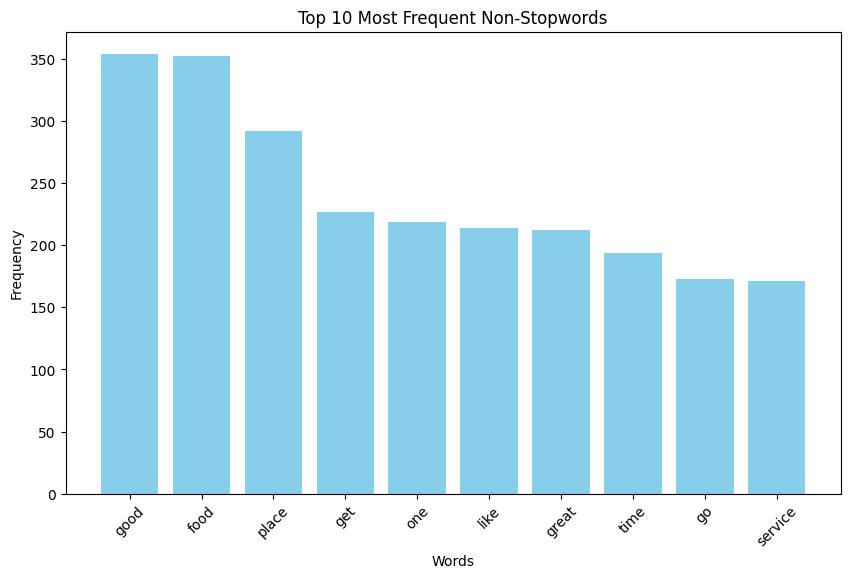

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of non_stopwords and count the frequency of each word
word_counts = Counter([word for sublist in data['non_stopwords'] for word in sublist])

# Get the 10 most common non-stopwords
common_words = word_counts.most_common(10)

# Split the words and their counts
words, counts = zip(*common_words)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Non-Stopwords')
plt.xticks(rotation=45)
plt.show()

In [ ]:
combined_text = ' '.join(data['stemming'])

print(combined_text)

dr goldberg offer everyth look gener practition he nice easi talk without patron he alway time see patient he affili topnotch hospit nyu parent explain import case someth happen need surgeri get referr see specialist without see first realli need im sit tri think complaint im realli draw blank unfortun frustrat dr goldberg patient repeat experi ive mani doctor nyc good doctor terribl staff seem staff simpli never answer phone usual take 2 hour repeat call get answer time want deal run problem mani doctor dont get offic worker patient medic need isnt anyon answer phone incomprehens work aggrav regret feel give dr goldberg 2 star dr goldberg doctor year like ive found offic fairli effici today actual got see doctor minut earli seem engag patient demeanor friendli yet authorit im glad dr goldberg doctor go dr goldberg 10 year think one 1st patient start mhmg he great year realli big pictur former gyn dr markoff found fibroid explor option patient understand doesnt judg ask right question 

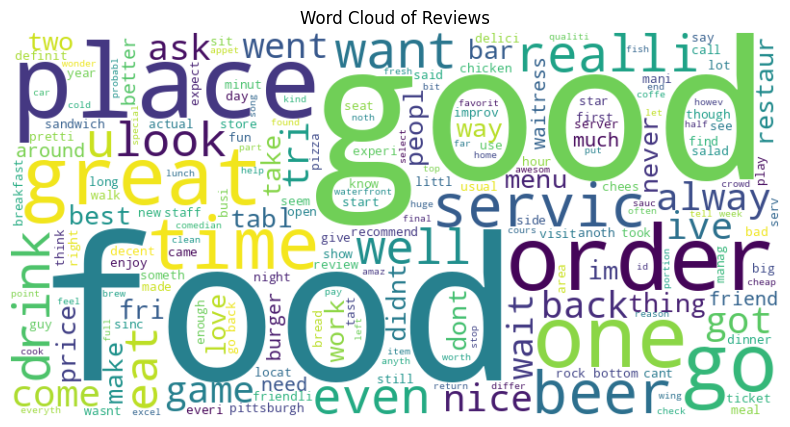

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

## Lemmatization

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in text.split()]  # pos='v' untuk kata kerja (verb)
    return ' '.join(lemmatized_tokens)

# Contoh penggunaan pada kolom 'clear_text' setelah menghapus stop words
data['lemmatized'] = data['clear_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-59-18f5f6adf0b0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lemmatized'] = data['clear_text'].apply(lemmatize_text)


In [ ]:
combined = ' '.join(data['lemmatized'])

print(combined)

dr goldberg offer everything i look for in a general practitioner hes nice and easy to talk to without be patronize hes always on time in see his patients hes affiliate with a topnotch hospital nyu which my parent have explain to me be very important in case something happen and you need surgery and you can get referrals to see specialists without have to see him first really what more do you need im sit here try to think of any complaints i have about him but im really draw a blank unfortunately the frustration of be dr goldbergs patient be a repeat of the experience ive have with so many other doctor in nyc good doctor terrible staff it seem that his staff simply never answer the phone it usually take 2 hours of repeat call to get an answer who have time for that or want to deal with it i have run into this problem with many other doctor and i just dont get it you have office workers you have patients with medical need why isnt anyone answer the phone its incomprehensible and not wor

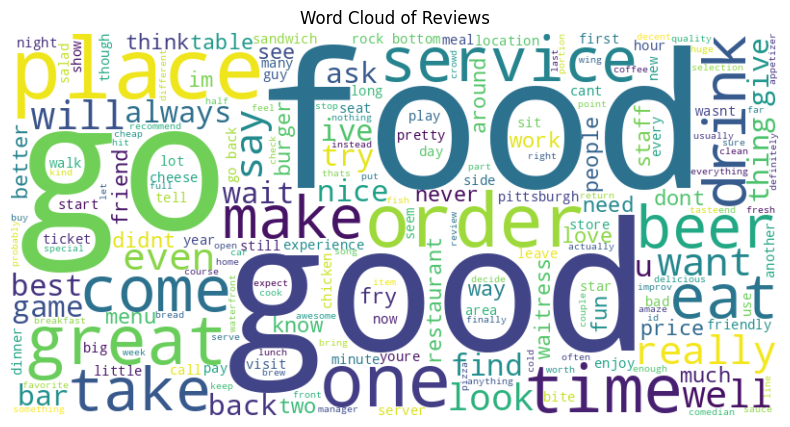

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

In [ ]:
data.head()

,text,business_id,clear_text,tokens,non_stopwords,stemming,lemmatized
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg offers everything i look for in a ...,"[dr, goldberg, offers, everything, i, look, fo...","[dr, goldberg, offers, everything, look, gener...",dr goldberg offer everyth look gener practitio...,dr goldberg offer everything i look for in a g...
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA,unfortunately the frustration of being dr gold...,"[unfortunately, the, frustration, of, being, d...","[unfortunately, frustration, dr, goldbergs, pa...",unfortun frustrat dr goldberg patient repeat e...,unfortunately the frustration of be dr goldber...
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg has been my doctor for years and i...,"[dr, goldberg, has, been, my, doctor, for, yea...","[dr, goldberg, doctor, years, like, ive, found...",dr goldberg doctor year like ive found offic f...,dr goldberg have be my doctor for years and i ...
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA,been going to dr goldberg for over 10 years i ...,"[been, going, to, dr, goldberg, for, over, 10,...","[going, dr, goldberg, 10, years, think, one, 1...",go dr goldberg 10 year think one 1st patient s...,be go to dr goldberg for over 10 years i think...
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA,got a letter in the mail last week that said d...,"[got, a, letter, in, the, mail, last, week, th...","[got, letter, mail, last, week, said, dr, gold...",got letter mail last week said dr goldberg mov...,get a letter in the mail last week that say dr...


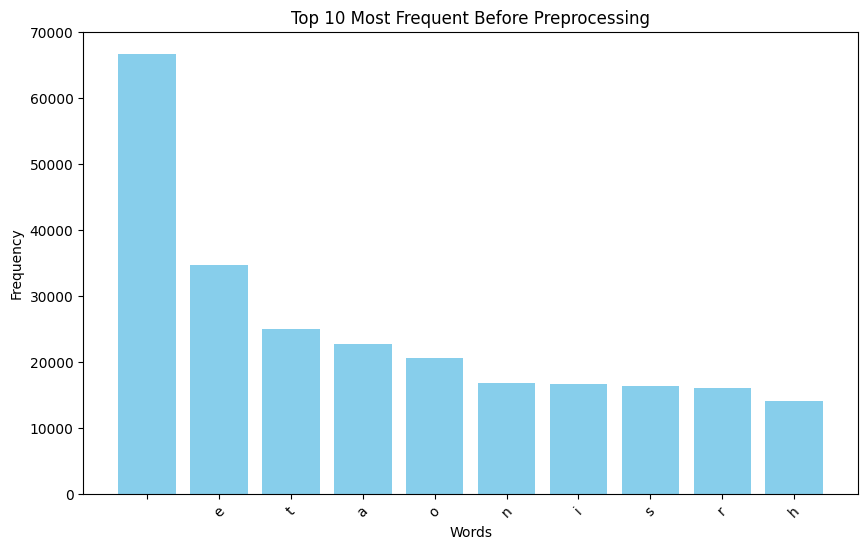

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Flatten the list of non_stopwords and count the frequency of each word
word_counts = Counter([word for sublist in data['text'] for word in sublist])

# Get the 10 most common non-stopwords
common_words = word_counts.most_common(10)

# Split the words and their counts
words, counts = zip(*common_words)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Before Preprocessing')
plt.xticks(rotation=45)
plt.show()

# Modelling

##Labelling dengan vader

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# inisialisasi vader
vader = SentimentIntensityAnalyzer()

# Func untuk menentukan label (Pos / Neg) berdasarkan nilai vader : neg,neu,pos
# nilai score = nilai compound

def vader_sentimen(text):
  score = vader.polarity_scores(text)
  compound = score['compound']

  if compound >= 0.05:
    label = 'positive'
  elif compound <= -0.05:
    label = 'negative'
  else:
    label = 'netral'
  return label,score

data[['sentiment','Score']] = data['text'].apply(lambda x: pd.Series(vader_sentimen(x)))
data = pd.concat([data.drop(['Score'],axis=1), data['Score'].apply(pd.Series)], axis = 1)

<ipython-input-65-07793df3066b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['sentiment','Score']] = data['text'].apply(lambda x: pd.Series(vader_sentimen(x)))
<ipython-input-65-07793df3066b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['sentiment','Score']] = data['text'].apply(lambda x: pd.Series(vader_sentimen(x)))


In [ ]:
data.head()

,text,business_id,clear_text,tokens,non_stopwords,stemming,lemmatized,sentiment,neg,neu,pos,compound
0,dr. goldberg offers everything i look for in a...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg offers everything i look for in a ...,"[dr, goldberg, offers, everything, i, look, fo...","[dr, goldberg, offers, everything, look, gener...",dr goldberg offer everyth look gener practitio...,dr goldberg offer everything i look for in a g...,positive,0.019,0.925,0.056,0.3708
1,"Unfortunately, the frustration of being Dr. Go...",vcNAWiLM4dR7D2nwwJ7nCA,unfortunately the frustration of being dr gold...,"[unfortunately, the, frustration, of, being, d...","[unfortunately, frustration, dr, goldbergs, pa...",unfortun frustrat dr goldberg patient repeat e...,unfortunately the frustration of be dr goldber...,negative,0.117,0.860,0.023,-0.8997
2,Dr. Goldberg has been my doctor for years and ...,vcNAWiLM4dR7D2nwwJ7nCA,dr goldberg has been my doctor for years and i...,"[dr, goldberg, has, been, my, doctor, for, yea...","[dr, goldberg, doctor, years, like, ive, found...",dr goldberg doctor year like ive found offic f...,dr goldberg have be my doctor for years and i ...,positive,0.000,0.772,0.228,0.9298
3,Been going to Dr. Goldberg for over 10 years. ...,vcNAWiLM4dR7D2nwwJ7nCA,been going to dr goldberg for over 10 years i ...,"[been, going, to, dr, goldberg, for, over, 10,...","[going, dr, goldberg, 10, years, think, one, 1...",go dr goldberg 10 year think one 1st patient s...,be go to dr goldberg for over 10 years i think...,positive,0.000,0.959,0.041,0.6249
4,Got a letter in the mail last week that said D...,vcNAWiLM4dR7D2nwwJ7nCA,got a letter in the mail last week that said d...,"[got, a, letter, in, the, mail, last, week, th...","[got, letter, mail, last, week, said, dr, gold...",got letter mail last week said dr goldberg mov...,get a letter in the mail last week that say dr...,negative,0.091,0.866,0.043,-0.4075


In [ ]:
print(data.dtypes)

text              object
business_id       object
clear_text        object
tokens            object
non_stopwords     object
stemming          object
lemmatized        object
sentiment         object
neg              float64
neu              float64
pos              float64
compound         float64
dtype: object


In [ ]:
# Assuming you have a dataset 'data' with 'text' and 'label' columns
X = data['text']
y = data['sentiment']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using Bag of Words (BoW) representation
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

# Predict sentiment labels for test data
y_pred = nb_classifier.predict(X_test_vectorized)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation metrics
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-score: {:.3f}".format(f1))

Accuracy: 0.850
Precision: 0.863
Recall: 0.850
F1-score: 0.797


## Aplication

In [ ]:
top_business_ids = data['business_id'].value_counts().head(10)  # Change 10 to the number of top business IDs you want
print(top_business_ids)

business_id
McikHxxEqZ2X0joaRNKlaw    83
sbW8qHJgzEIH42B0S-3New    47
P1fJb2WQ1mXoiudj8UE44w    45
b9WZJp5L1RZr4F1nxclOoQ    34
tv8cS4aaA1VDaInYgggb6g    32
6ilJq_05xRgek_8qUp36-g    32
MKyk4F4HSzHF8v-4cYe3Ww    26
3gmBc0qN_LtGbZAjTtHWZg    16
1qCuOcks5HRv67OHovAVpg    15
eT5Ck7Gg1dBJobca9VFovw    13
Name: count, dtype: int64


In [ ]:
selected_columns = data[data['business_id'] == 'McikHxxEqZ2X0joaRNKlaw']

In [ ]:
selected_columns

,text,business_id,clear_text,tokens,non_stopwords,stemming,lemmatized,sentiment,neg,neu,pos,compound
372,Rock Bottom Brewery in Homestead is always a g...,McikHxxEqZ2X0joaRNKlaw,rock bottom brewery in homestead is always a g...,"[rock, bottom, brewery, in, homestead, is, alw...","[rock, bottom, brewery, homestead, always, goo...",rock bottom breweri homestead alway good time ...,rock bottom brewery in homestead be always a g...,positive,0.017,0.913,0.070,0.9830
373,"Horrible beer, horrible service, horrible menu",McikHxxEqZ2X0joaRNKlaw,horrible beer horrible service horrible menu,"[horrible, beer, horrible, service, horrible, ...","[horrible, beer, horrible, service, horrible, ...",horribl beer horribl servic horribl menu,horrible beer horrible service horrible menu,negative,0.778,0.222,0.000,-0.8885
374,SUMMARY:\nIf I was in the area and no one had ...,McikHxxEqZ2X0joaRNKlaw,summary\nif i was in the area and no one had a...,"[summary, if, i, was, in, the, area, and, no, ...","[summary, area, one, better, suggestion, go, m...",summari area one better suggest go might come ...,summary if i be in the area and no one have a ...,positive,0.094,0.755,0.151,0.8943
375,I am a big fan of Rock Bottom.\nThere are seve...,McikHxxEqZ2X0joaRNKlaw,i am a big fan of rock bottom\nthere are sever...,"[i, am, a, big, fan, of, rock, bottom, there, ...","[big, fan, rock, bottom, several, dishes, mone...",big fan rock bottom sever dish money appet sea...,i be a big fan of rock bottom there be several...,positive,0.030,0.858,0.112,0.9421
376,I thought this place was pretty decent. My fri...,McikHxxEqZ2X0joaRNKlaw,i thought this place was pretty decent my frie...,"[i, thought, this, place, was, pretty, decent,...","[thought, place, pretty, decent, friend, still...",thought place pretti decent friend still reel ...,i think this place be pretty decent my friend ...,positive,0.040,0.728,0.233,0.9316
...,...,...,...,...,...,...,...,...,...,...,...,...
450,I am not a fan of chain restaurants typically ...,McikHxxEqZ2X0joaRNKlaw,i am not a fan of chain restaurants typically ...,"[i, am, not, a, fan, of, chain, restaurants, t...","[fan, chain, restaurants, typically, slowing, ...",fan chain restaur typic slow break boyfriend w...,i be not a fan of chain restaurants typically ...,positive,0.010,0.764,0.226,0.9988
451,Be careful. The servers can't pay attention to...,McikHxxEqZ2X0joaRNKlaw,be careful the servers cant pay attention to s...,"[be, careful, the, servers, cant, pay, attenti...","[careful, servers, cant, pay, attention, save,...",care server cant pay attent save live manag ca...,be careful the servers cant pay attention to s...,positive,0.053,0.682,0.265,0.7856
452,I always enjoy Rock Bottom. Standard beers on ...,McikHxxEqZ2X0joaRNKlaw,i always enjoy rock bottom standard beers on t...,"[i, always, enjoy, rock, bottom, standard, bee...","[always, enjoy, rock, bottom, standard, beers,...",alway enjoy rock bottom standard beer tap alwa...,i always enjoy rock bottom standard beers on t...,positive,0.036,0.693,0.272,0.9945
453,"This is a ""Okay"" place to eat. The food is n...",McikHxxEqZ2X0joaRNKlaw,this is a okay place to eat the food is noth...,"[this, is, a, okay, place, to, eat, the, food,...","[okay, place, eat, food, nothing, special, gue...",okay place eat food noth special guess go beer...,this be a okay place to eat the food be nothin...,netral,0.081,0.841,0.079,-0.0384


In [ ]:
combined_final = ' '.join(selected_columns['lemmatized'])

print(combined_final)

rock bottom brewery in homestead be always a good time they brew their own semimicro brew here and generally have as many as eight brew to choose from saturday night c and i stop by to have a little dinner and enjoy some of their frosty beverages our first issue of the night be get to rock bottom as the restaurant be locate in homestead a trip across the hi level bridge be in order little do we realize that the bridge be under construction and it take nearly 40 minutes to get across it upon arrive at the restaurant we be present with the task of find a place to park which prove to be a daunt task this place be absolutely pack due to several locations share a park lot after we get inside our wait be about 45 minutes but luckily we be able to find a seat inside the pack bar while we wait the food at rock bottom be quite tasty but it be all pretty standard bar fare with the nachos and burgers lead their menu they also have entrees such as steaks but this place be not exactly know for thei

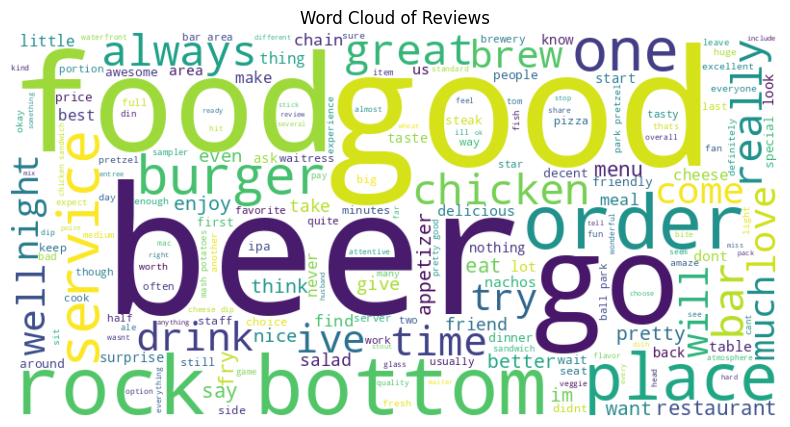

In [ ]:
from wordcloud import WordCloud

# Buat word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_final)

# Tampilkan word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

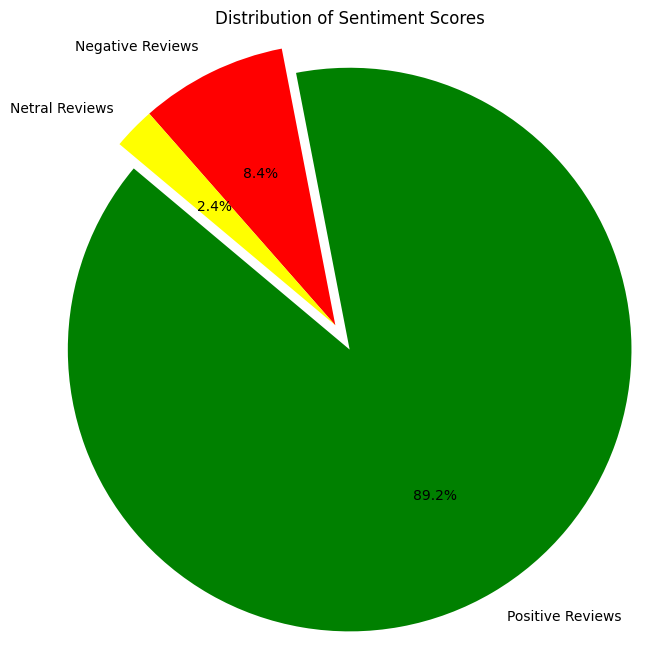

In [ ]:
if 'sentiment' in selected_columns:
    # Count positive negatives review
    positive_reviews = len(selected_columns [selected_columns ['sentiment'] == 'positive'])
    negative_reviews = len(selected_columns [selected_columns ['sentiment'] == 'negative'])
    netral_reviews = len(selected_columns [selected_columns ['sentiment'] == 'netral'])
    # Pie Chart Data
    labels = ['Positive Reviews', 'Negative Reviews', 'Netral Reviews']
    sizes = [positive_reviews, negative_reviews, netral_reviews]
    colors = ['green', 'red', 'yellow']
    explode = (0.1, 0, 0)  # explode 1st slice

    # Plotting the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Sentiment Scores')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Show plot
    plt.show()
else:
    print("Kolom 'sentiment' tidak ditemukan dalam DataFrame.")

In [ ]:
if 'sentiment' in selected_columns :
    # Filter ulasan negatif
    negative_reviews = selected_columns [selected_columns ['sentiment'] == 'negative']

    # Sortir ulasan negatif berdasarkan skor 'neg' secara menurun
    most_critical_reviews = negative_reviews.sort_values(by='neg', ascending=False).head(3)

    print("Three Most Critical Reviews:")
    for index, review in most_critical_reviews.iterrows():
        print("\nReview Text:", review['text'])
        print("Negative Score:", review['neg'])
else:
    print("Kolom 'sentiment' tidak ditemukan dalam DataFrame")

Three Most Critical Reviews:

Review Text: Horrible beer, horrible service, horrible menu
Negative Score: 0.778

Review Text: Slow service
Below average food 
Ill pass
Negative Score: 0.318

Review Text: Poor service and food. I waited 20 minutes at the bar for someone to just acknowledge my presence. They finally brought my food out and left it without asking for me to pay.... So I had to wait an additional 15 minutes to find someone to pay. Yes, I had to TRY and give them money.

On to the important part... Food was terrible. I had a burger and it was pathetic.
Negative Score: 0.155


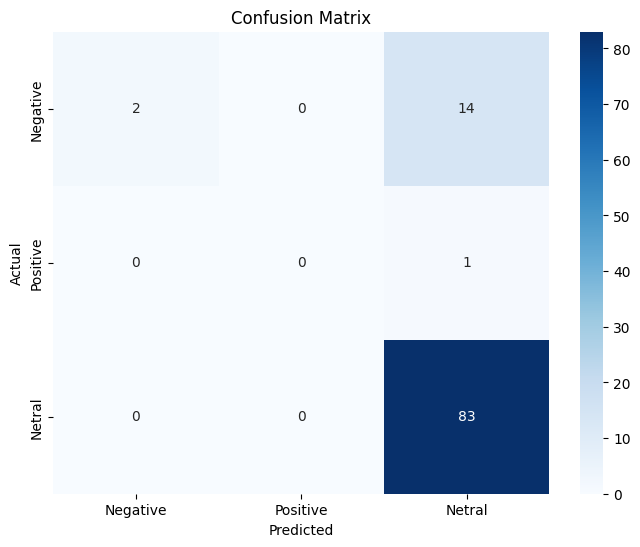

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive', 'Netral'], yticklabels=['Negative', 'Positive', 'Netral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()